In [10]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Config

features = pd.read_csv('../data/processed/pre_match_features.csv')
# Display first few rows of the dataframe
features.head()

,fighter_id,opponent_id,match_date,ratings_diff,experience_diff,days_since_last_fought_diff,fighter_days_since_last_fought,opponent_days_since_last_fought,division,stage,label
0,376,356,2013-07-01,0.0,0,0,365,365,Mixed Steel Longsword,NaN,0
1,376,637,2013-07-01,0.0,1,0,365,365,Mixed Steel Longsword,NaN,0
2,376,635,2013-07-01,0.0,2,0,365,365,Mixed Steel Longsword,NaN,0
3,376,326,2013-07-01,0.0,3,0,365,365,Mixed Steel Longsword,NaN,0
4,376,576,2013-07-01,0.0,4,0,365,365,Mixed Steel Longsword,NaN,0


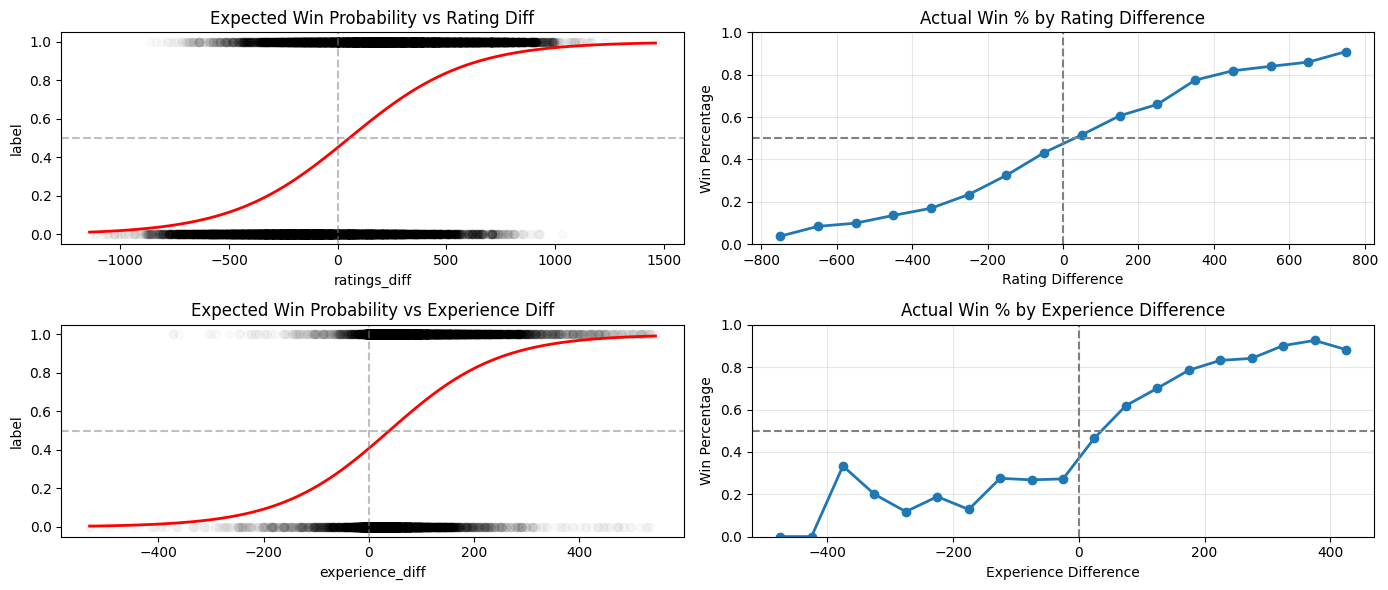

In [20]:
# 2. Setup the plot
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
axes = axes.flatten()

# --- Plot A: The Logistic Fit (Model View) ---
# sns.regplot with logistic=True automatically fits the Sigmoid curve
sns.regplot(
    x='ratings_diff', 
    y='label', 
    data=features, 
    logistic=True, 
    ci=None, 
    scatter_kws={'alpha': 0.02, 'color': 'black'}, # High transparency helps visualize density
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[0]
)
axes[0].set_title("Expected Win Probability vs Rating Diff")
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)

# --- Plot B: Binned Win Rates (Reality View) ---
# Create bins every 100 points (adjust range as needed)
bins = np.arange(-800, 900, 100) 
features['bin'] = pd.cut(features['ratings_diff'], bins=bins)

# Calculate win rate per bin
bin_stats = features.groupby('bin', observed=True)['label'].mean().reset_index()
bin_stats['bin_center'] = bin_stats['bin'].apply(lambda x: x.mid)

# Plot
axes[1].plot(bin_stats['bin_center'], bin_stats['label'], marker='o', linewidth=2)
axes[1].set_title("Actual Win % by Rating Difference")
axes[1].set_xlabel("Rating Difference")
axes[1].set_ylabel("Win Percentage")
axes[1].axhline(0.5, color='gray', linestyle='--')
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)


sns.regplot(
    x='experience_diff', 
    y='label', 
    data=features, 
    logistic=True, 
    ci=None, 
    scatter_kws={'alpha': 0.02, 'color': 'black'}, # High transparency helps visualize density
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[2]
)
axes[2].set_title("Expected Win Probability vs Experience Diff")
axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)

bins = np.arange(-500, 500, 50)
features['bin'] = pd.cut(features['experience_diff'], bins=bins)
bin_stats = features.groupby('bin', observed=True)['label'].mean().reset_index()
bin_stats['bin_center'] = bin_stats['bin'].apply(lambda x: x.mid)
axes[3].plot(bin_stats['bin_center'], bin_stats['label'], marker='o', linewidth=2)
axes[3].set_title("Actual Win % by Experience Difference")
axes[3].set_xlabel("Experience Difference")
axes[3].set_ylabel("Win Percentage")
axes[3].axhline(0.5, color='gray', linestyle='--')
axes[3].axvline(0, color='gray', linestyle='--')
axes[3].set_ylim(0, 1)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# Create the same bins you used for the plot
bins = np.arange(-500, 500, 50) # Adjust step size to match your plot
features['exp_bin'] = pd.cut(features['experience_diff'], bins=bins)

# Check the counts
bin_counts = features['exp_bin'].value_counts().sort_index()
spike = features[features['exp_bin'] == pd.Interval(-400, -350, closed='right')]  # Example for one bin
spike[['match_date', 'ratings_diff', 'experience_diff', 'division', 'stage', 'label']].rename(columns={'label': 'outcome'}).reset_index(drop=True)

,match_date,ratings_diff,experience_diff,division,stage,outcome
0,2024-04-01,-611.3,-386,Mixed Steel Longsword,Group 1,0
1,2024-04-01,-742.0,-396,Mixed Steel Longsword,Group 1,0
2,2024-06-01,-637.8,-373,Mixed Steel Longsword,Best 32,1
3,2024-09-01,-277.6,-361,Mixed Steel Longsword,Final,1
4,2025-01-01,-548.0,-373,Mixed Steel Longsword,elimination round 2,1
5,2025-02-01,-261.4,-396,Mixed Steel Longsword,Pool Set 1,0
6,2025-03-01,-512.8,-368,Mixed Steel Longsword (Tier A),Pools,0
7,2025-05-01,-560.7,-364,Men's Steel Longsword (Pools),Pool 2,0
8,2025-09-01,-366.4,-363,Mixed Steel Longsword (Advanced),pool 6,0


In [42]:
# compute number of wins and losses
features['outcome'] = features['label'].map({1: 'win', 0: 'loss'})
outcome_counts = features['outcome'].value_counts()
outcome_counts

outcome
win     14515
loss    14169
Name: count, dtype: int64

In [54]:
matches = pd.read_csv('../data/raw/tournament_histories.csv')
matches['tournament_date'] = pd.to_datetime(matches['tournament_date'])
matches['opponent_id'] = matches['opponent_id'].astype('Int64')
matches = matches.sort_values(by='tournament_date')
matches = matches.reset_index(drop=True)
matches.head()

/tmp/ipykernel_673337/2065031913.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  matches['tournament_date'] = pd.to_datetime(matches['tournament_date'])


,fighter_id,division,stage,tournament_name,tournament_date,opponent,opponent_id,outcome,opponent_rating,win_chance
0,376,Mixed Steel Longsword,NaN,Longpoint 2013,2013-07-01,Jan Deneke,356,LOSS,Unrated,NaN
1,376,Mixed Steel Longsword,NaN,Longpoint 2013,2013-07-01,Sean Franklin,637,LOSS,Unrated,NaN
2,376,Mixed Steel Longsword,NaN,Longpoint 2013,2013-07-01,Mark Winkelman,635,LOSS,Unrated,NaN
3,376,Mixed Steel Longsword,NaN,Longpoint 2013,2013-07-01,Doug Bahnick,326,LOSS,Unrated,NaN
4,376,Mixed Steel Longsword,NaN,Longpoint 2013,2013-07-01,John O'Connor,576,LOSS,Unrated,NaN


In [65]:
print(len(matches) - len(features))
# see if there are duplicate matches
duplicates = features.drop_duplicates(subset=['fighter_id', 'opponent_id', 'match_date'], keep='first', inplace=False)
print(duplicates[['fighter_id', 'opponent_id', 'match_date']].head())
print(f"Number of duplicate matches: {len(duplicates)}")
print(duplicates.tail())


105
   fighter_id  opponent_id  match_date
0         376          356  2013-07-01
1         376          637  2013-07-01
2         376          635  2013-07-01
3         376          326  2013-07-01
4         376          576  2013-07-01
Number of duplicate matches: 27014
       fighter_id  opponent_id  match_date  ratings_diff  experience_diff  \
28679       19666         2075  2025-12-01        -275.0                3   
28680       18678        10858  2025-12-01         -72.6               22   
28681       18678        19591  2025-12-01          55.1               24   
28682       11165        13639  2025-12-01         526.1              136   
28683       18849        16066  2025-12-01        -116.1               13   

       days_since_last_fought_diff  fighter_days_since_last_fought  \
28679                            0                             365   
28680                          -31                              30   
28681                         -335                    

In [75]:
features['match_date'] = pd.to_datetime(features['match_date'])
print(features[(features['fighter_id'] == 1831) & (features['opponent_id'] == 711)].sort_values(by='match_date'))
# matches[matches['fighter_id'] == 356]

       fighter_id  opponent_id match_date  ratings_diff  experience_diff  \
1938         1831          711 2018-02-01        -207.3              -21   
4093         1831          711 2019-07-01        -167.1              -82   
4103         1831          711 2019-07-01        -167.1              -80   
9436         1831          711 2023-05-01        -158.4              -88   
25569        1831          711 2025-09-01        -132.5              -94   

       days_since_last_fought_diff  fighter_days_since_last_fought  \
1938                           153                             215   
4093                            31                             122   
4103                            31                             122   
9436                             0                             120   
25569                         -122                              62   

       opponent_days_since_last_fought                          division  \
1938                                62        